<a href="https://colab.research.google.com/github/ashutoshsinha25/tensorflow-developement/blob/main/Transfer%20Learning%20in%20TensorFlow%20Part1%20%3A%20Feature%20extraction/04_transfer_learning_with_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
tf.__version__

'2.7.0'

# Transfer Learning with Tensorflow part 1 : Feature Extraction 

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benifits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [ ]:
# are we using a gpu
!nvidia-smi

Sun Jan 23 16:10:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with tht data 

In [ ]:
# Get data a(10% of 10 food classes from Food101)

import zipfile 

# download the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

# Unzip the downloaded file 
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-01-23 16:12:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   176MB/s    in 0.9s    

2022-01-23 16:12:42 (176 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How manu images in each folder

import os 

# wlak through 10 percent data directory and list number of files
for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Create data loaders (preparing the data) 

We'll use the `ImageDataGenerator` class to load in our imahes in batches

In [ ]:
# Setup data input 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
# in deep learning examples , capital variables generally is hyper paramaters which is used somewherer in our code 

train_dir = '/content/10_food_classes_10_percent/train/'
test_dir = '/content/10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')



Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (Things to run whilst our model trains)

callbacks are extra functionality you can add to your model to be performed during or after training. Some of the most callbacks : 

* Tracking experiments with the `TensorBoard` callback 
* Model checkpoint with the `ModelCheckpoint` callback
* Stopping a model from training (before it trains too long and overfit ) with the `EarlyStopping` callabck


In [ ]:
# Create a TensorBoard callback ( functionized because we need to create a anew one for each model)
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TnsorBoard log file to : {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub. We can access pretrained models on [TensorFlow Hub](https://https://tfhub.dev/)

Browsing the tensorflow hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Lets compair the following two models 
 
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
 # Import dependencies 

 import tensorflow as tf 
 import tensorflow_hub as hub 
 from tensorflow.keras import layers

In [ ]:
# demo 
IMAGE_SHAPE , IMAGE_SHAPE + (3,)

((224, 224), (224, 224, 3))

In [ ]:
# Lets make a create model function to create a model from url 

def create_model(model_url , num_classes = 10):
  ''' 
  Takes a tensorflow hub url and creates a keras sequential model with it.

  Args:
    model_ul(str) : a tensorflow hub feature extraction url.
    numclasses (int): number of output neurons in the output layers,
                      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled keras sequential model with model_url as feature extractor layers and
    dense output layer with num_classes output neurons
  '''
  # Download the pretrained model and save it as keras layer's
  feature_extractor_layers = hub.KerasLayer(model_url,
                                            trainable = False,
                                            name = 'feature_extraction_layer',
                                            input_shape = IMAGE_SHAPE + (3,)) # freeze already learned patterns
  # create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layers,
                               layers.Dense(num_classes,activation='softmax',name = 'output_layer')
  ])

  return model

### Createing ResNet TensorFlow Hub Feature Exrtractor Model

In [ ]:
# demo
train_data_10_percent.num_classes

10

In [ ]:
# Create resnet model 
resnet_model = create_model(resnet_url,
                             num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the resnet model to 10 percent of 10 classes
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                           experiment_name='resnet50V2')])

Saving TnsorBoard log file to : tensorflow_hub/resnet50V2/20220123 - 173449
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 2.0101 - accuracy: 0.3453 - val_loss: 1.2288 - val_accuracy: 0.6020
Epoch 2/5
24/24 [==============================] - 22s 946ms/step - loss: 0.9411 - accuracy: 0.7200 - val_loss: 0.8781 - val_accuracy: 0.7128
Epoch 3/5
24/24 [==============================] - 22s 922ms/step - loss: 0.6361 - accuracy: 0.8240 - val_loss: 0.7538 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 22s 922ms/step - loss: 0.4895 - accuracy: 0.8747 - val_loss: 0.6991 - val_accuracy: 0.7736
Epoch 5/5
24/24 [==============================] - 21s 913ms/step - loss: 0.3973 - accuracy: 0.9000 - val_loss: 0.6729 - val_accuracy: 0.7768


Wow!

That. Is. Incredible. Out transfer learning feature extractor model out performed ALL OF THE PREVIOUS models we built by hand.. substantially and i a quicker trainer time AND with only 10% of the training example

In [ ]:
# Lets create a function to plot our loss curves 
# tidbit : you could put a function like this into a script called " helper.py" and import it when you need it....
import matplotlib.pyplot as plt 

# PLot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics
  Args:
    history : tensorflow history object
  Returns:
    Plots of training/ validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss 
  plt.plot(epochs,loss,label = 'training_loss')
  plt.plot(epochs,val_loss,label ='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot acuracy
  plt.figure()
  plt.plot(epochs,accuracy,label = 'training_accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


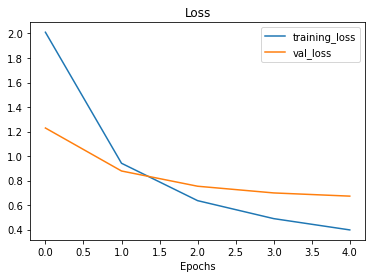

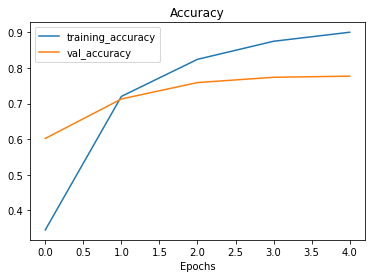

In [ ]:
plot_loss_curves(resnet_history)

### Creating and tesing EfficientNetB0 Tensorflow Hub Feature Extraction Model

In [ ]:
# Create efficientnet B0 feature extractor model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes= train_data_10_percent.num_classes)

# Compile the model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer= tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

#Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                       experiment_name='efficientnetb0')])

Saving TnsorBoard log file to : tensorflow_hub/efficientnetb0/20220123 - 181728
Epoch 1/5
24/24 [==============================] - 33s 898ms/step - loss: 1.9227 - accuracy: 0.3960 - val_loss: 1.3456 - val_accuracy: 0.7132
Epoch 2/5
24/24 [==============================] - 19s 814ms/step - loss: 1.0897 - accuracy: 0.7653 - val_loss: 0.8963 - val_accuracy: 0.8108
Epoch 3/5
24/24 [==============================] - 19s 818ms/step - loss: 0.7754 - accuracy: 0.8333 - val_loss: 0.7170 - val_accuracy: 0.8328
Epoch 4/5
24/24 [==============================] - 19s 819ms/step - loss: 0.6214 - accuracy: 0.8707 - val_loss: 0.6252 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.5239 - accuracy: 0.8947 - val_loss: 0.5666 - val_accuracy: 0.8600


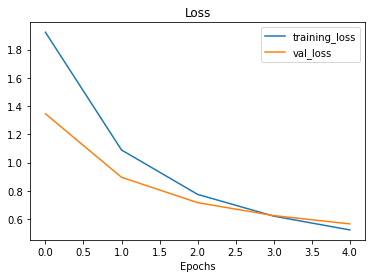

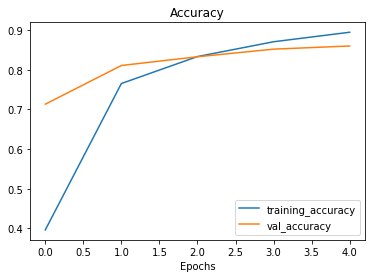

In [ ]:
# loss curve for efficientnetb0 model
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* `As is` **transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes , none of your own).
* `Feature Extraction` **transfer learning** - use the prelearned patterns of an existing model (e.g.EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes og ImageNet --> 10 classes of your own food data).
* `Fine-tuning` **transfer learning** - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (inclusing new output kayers).


## Comparing our models result using TensorBoard

> **Note**- When you upload things to tensorboard.dev, your expriment are public. So if you're running private experiments( things you don't want others to see) do not upload them to TensorBoard

In [ ]:
# Upload tensorboard dev records 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name 'EfficientNetB0 cs Resnet50V2'\
 --description "Comparing two different TF hub feature exraction model architectures using 10% of the training data" \
 --one_shot

our tensorboard experiments are uploaded publically here : https://tensorboard.dev/experiment/ALQzSy8rTDiKZLEN3M1YCw/

In [ ]:
# Check out what tensorboard experiments you have 
!tensorboard dev list

https://tensorboard.dev/experiment/ALQzSy8rTDiKZLEN3M1YCw/
	Name                 EfficientNetB0 cs Resnet50V2
	Description          Comparing two different TF hub feature exraction model architectures using 10% of the training data
	Id                   ALQzSy8rTDiKZLEN3M1YCw
	Created              2022-01-23 18:58:35 (4 minutes ago)
	Updated              2022-01-23 18:58:38 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5796311
Total: 1 experiment(s)


In [ ]:
# delete an experiment
# !tensorboard dev delete -- experiment_id ALQzSy8rTDiKZLEN3M1YCw